### Vessel Type Classification Model Using Trajectory Features

In [24]:
#import needed libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score 

import matplotlib.pyplot as plt 

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Data Pre-processing

In [2]:
#import data
trajectory_features = pd.read_csv('trajectory_features.csv')

In [3]:
#df for plotting class distribution
classes = pd.DataFrame(trajectory_features.groupby(['label'])['avg_speed'].count())

In [4]:
classes.sort_values(by='avg_speed',ascending=False,inplace=True)

In [5]:
def get_cmap(n, name='winter'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

color_list = []
cmap = get_cmap(len(classes.index))
for i in range(len(classes.index)):
    color_list.append(cmap(i))

#### Check Class Label Balance

[]

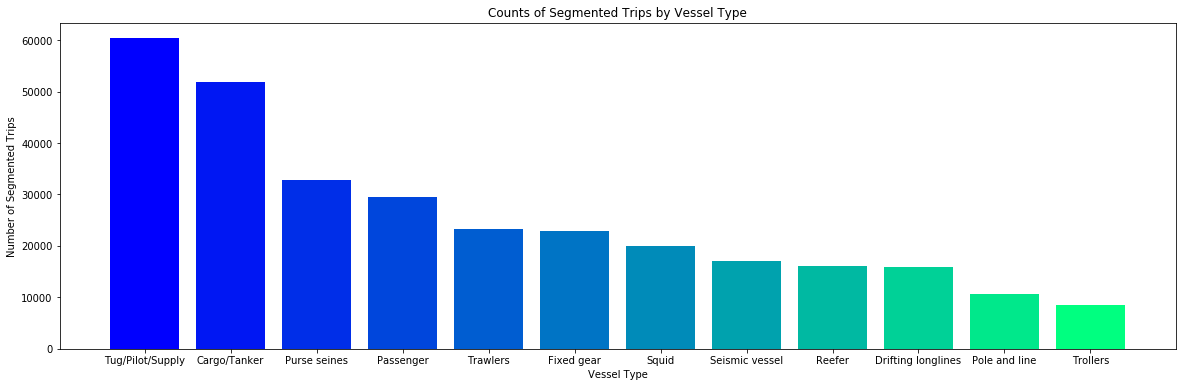

In [6]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)

ax.bar(height=classes['avg_speed'],x=list(classes.index),color=color_list)

ax.set_title("Counts of Segmented Trips by Vessel Type")
ax.set_xlabel("Vessel Type")
ax.set_ylabel("Number of Segmented Trips")

plt.plot()

In [7]:
print("Number of unlabelled Data Points: {}".format(519339-461809))
print("% Unlabelled: {}%".format(round((57530 / 519339)* 100,3)))

Number of unlabelled Data Points: 57530
% Unlabelled: 11.078%


In [8]:
#create a dataframe to map the classes to a numeric value for modeling
df_dict = {'vessel_type':list(classes.index),
          'vessel_type_code':[i+1 for i in range(len(classes.index))]}

class_labels = pd.DataFrame(df_dict)

In [9]:
#merge to initial df
trajectory_features = pd.merge(left=trajectory_features,right=class_labels,how='left',
                               left_on='label',right_on='vessel_type')

In [10]:
#fill in unlabelled data with -1, to use later for semi-supervised learning
trajectory_features['vessel_type_code'].fillna(value=-1,inplace=True)

In [11]:
#store the unlabelled data and labeled in a separate df
traj_unlabel = trajectory_features[trajectory_features['vessel_type_code']==-1]
traj_label = trajectory_features[trajectory_features['vessel_type_code']!= -1]

In [12]:
#keep only the columns needed
col_list = ['vessel_type_code','avg_speed','distance','max_lat','max_lon','med_lat','med_lon','min_lat','min_lon']
traj_label = traj_label[col_list]

In [46]:
#set up data for modeling

X = np.asarray(traj_label[['avg_speed','distance','max_lat','max_lon','med_lat','med_lon','min_lat','min_lon']])
Y = np.asarray(traj_label['vessel_type_code'])

#initial train and test split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=13)
#hold out additional data for final validation
x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size=0.125,random_state=13)
#data split: training = 70%, testing = 20%, validation = 10%

### Train Initial RandomForestClassifier

In [47]:
#initialize baseline model
rfc = RandomForestClassifier(n_estimators=50,oob_score=True,max_features=None,random_state=13)
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=13, verbose=0,
                       warm_start=False)

In [48]:
test_score = rfc.score(x_test,y_test)
train_score = rfc.score(x_train,y_train)
print("test_score: {}".format(test_score))
print("train_score: {}".format(train_score))

test_score: 0.9603396684189244
train_score: 0.9991422751152568


In [52]:
# tune number of estimators first for graphing of how accuracy changes with 
#initialize grid search cross validation
param_test = {
    'n_estimators':[i for i in range(5,150,10)]}

gsearch1 = GridSearchCV(estimator=rfc, param_grid=param_test, 
                        scoring='balanced_accuracy',n_jobs=6,cv=3)

gsearch1.fit(x_test,y_test) #tune parameters on test data
print(gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 145} 0.8815751228355566


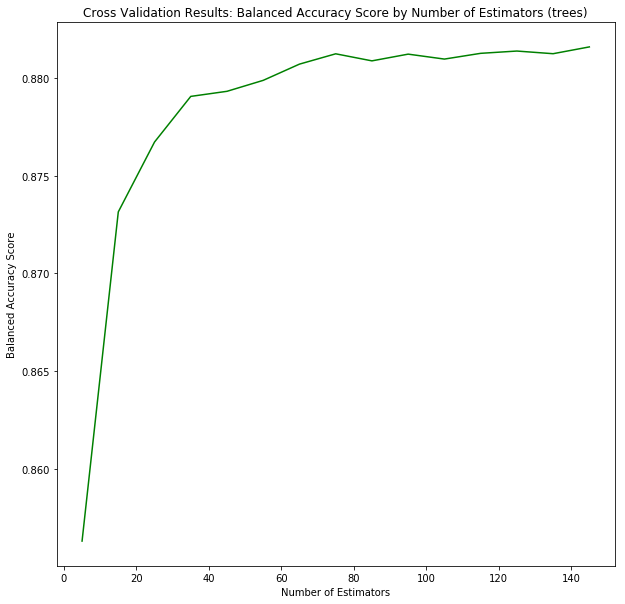

In [54]:
cv_results = pd.DataFrame(gsearch1.cv_results_)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.plot(cv_results['param_n_estimators'],cv_results['mean_test_score'],c='green')

ax.set_title("Cross Validation Results: Balanced Accuracy Score by Number of Estimators (trees)")
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Balanced Accuracy Score")
plt.show()

In [58]:
# tune number of estimators first for graphing of how accuracy changes with 
#initialize grid search cross validation
param_test = {
    'max_depth':range(2,10),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(1,6)}

gsearch2 = GridSearchCV(estimator=rfc, param_grid=param_test, 
                        scoring='balanced_accuracy',n_jobs=6,cv=3)

gsearch2.fit(x_test,y_test) #tune parameters on test data

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=True, random_state=13,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=6,
             param_grid={'max_depth'

In [57]:
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4} 0.6927119327337967


### Revised Model Results with Tuned Parameters

In [103]:
#updated model
rfc_final = RandomForestClassifier(n_estimators=145,oob_score=True,max_depth=9,min_samples_split=4)
rfc_final.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=145,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
#output classification metrics for training data
train_report = classification_report(y_train,rfc_final.predict(x_train),output_dict=True)
test_report = classification_report(y_test,rfc_final.predict(x_test),output_dict=True)
val_report = classification_report(y_val,rfc_final.predict(x_val),output_dict=True)

train_report = pd.DataFrame(train_report).transpose()
test_report = pd.DataFrame(test_report).transpose()
val_report = pd.DataFrame(val_report).transpose()

In [106]:
val_report

,f1-score,precision,recall,support
1.0,0.904032,0.928037,0.881238,7595.000000
2.0,0.839405,0.780361,0.908116,6432.000000
3.0,0.740710,0.637118,0.884531,4079.000000
4.0,0.864654,0.931238,0.806956,3709.000000
5.0,0.588499,0.648293,0.538803,2925.000000
6.0,0.639421,0.684211,0.600136,2946.000000
7.0,0.947975,0.945835,0.950124,2426.000000
8.0,0.604371,0.653449,0.562150,2140.000000
9.0,0.618609,0.702857,0.552395,2004.000000
10.0,0.810677,0.803528,0.817955,2005.000000


In [88]:
#plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[8.87e-01 3.93e-02 1.48e-02 7.20e-03 1.51e-02 1.07e-02 2.84e-04 1.94e-02
  2.92e-03 1.17e-03 1.12e-03 6.25e-04]
 [3.46e-02 9.02e-01 3.58e-03 4.11e-03 8.73e-03 8.40e-03 1.71e-03 8.22e-03
  2.20e-02 5.34e-03 1.45e-03 4.18e-04]
 [2.65e-03 7.05e-03 8.92e-01 1.50e-03 2.17e-02 2.44e-02 1.81e-03 1.92e-02
  7.26e-03 1.80e-02 4.57e-03 1.40e-04]
 [1.40e-02 3.92e-02 6.27e-02 8.15e-01 2.91e-02 1.04e-02 3.88e-04 1.21e-02
  4.04e-03 6.02e-03 6.06e-03 1.09e-03]
 [6.70e-03 8.29e-02 2.18e-01 8.32e-04 5.53e-01 7.36e-02 1.71e-03 1.32e-02
  2.10e-02 2.06e-02 0.00e+00 8.46e-03]
 [3.50e-04 3.49e-02 2.57e-01 2.50e-03 9.34e-02 5.75e-01 0.00e+00 2.20e-03
  6.00e-04 1.18e-02 2.13e-02 9.99e-05]
 [6.32e-03 1.04e-02 5.69e-04 1.33e-02 5.69e-05 0.00e+00 9.49e-01 2.28e-03
  1.20e-02 2.56e-03 3.19e-03 0.00e+00]
 [6.88e-02 8.34e-02 1.82e-02 2.83e-02 1.27e-01 2.57e-02 3.35e-03 5.67e-01
  2.47e-02 4.52e-02 7.77e-03 4.02e-04]
 [2.14e-02 2.11e-01 2.60e-02 8.39e-03 7.68e-03 7.97e-03 4.18e-02 5.8

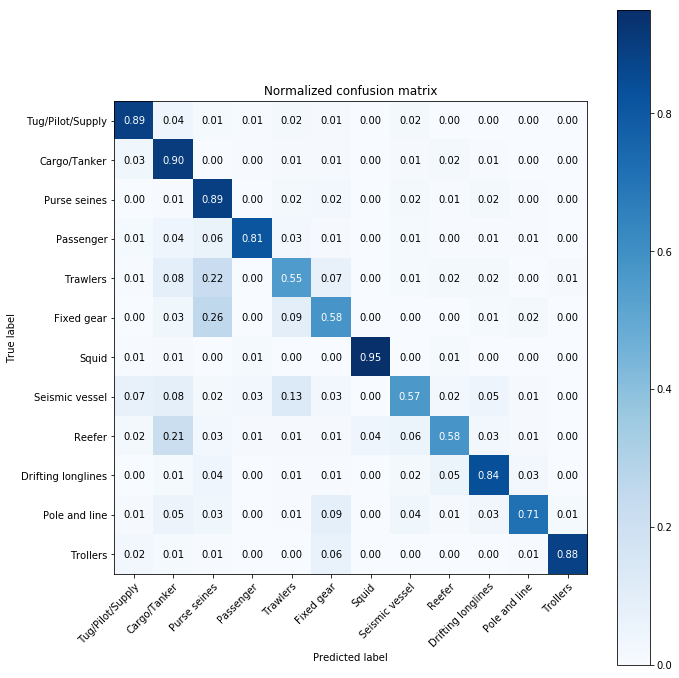

In [89]:
class_names = list(classes.index)
y_pred = rfc_final.predict(x_train)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, y_pred, classes=class_names,
                      normalize=True)

Normalized confusion matrix
[[8.86e-01 3.81e-02 1.63e-02 8.08e-03 1.40e-02 1.12e-02 3.30e-04 2.01e-02
  2.97e-03 1.07e-03 5.77e-04 1.24e-03]
 [3.49e-02 8.97e-01 3.12e-03 3.90e-03 7.80e-03 1.02e-02 2.44e-03 8.19e-03
  2.35e-02 6.14e-03 2.44e-03 5.85e-04]
 [1.99e-03 9.20e-03 8.85e-01 1.69e-03 2.04e-02 2.58e-02 1.69e-03 2.12e-02
  8.59e-03 1.99e-02 4.91e-03 0.00e+00]
 [1.38e-02 3.68e-02 5.92e-02 8.17e-01 2.85e-02 1.14e-02 3.41e-04 1.45e-02
  4.95e-03 6.31e-03 5.63e-03 1.02e-03]
 [7.39e-03 8.60e-02 2.20e-01 1.48e-03 5.54e-01 7.16e-02 2.53e-03 1.01e-02
  1.92e-02 1.99e-02 0.00e+00 7.60e-03]
 [4.35e-04 3.70e-02 2.60e-01 2.61e-03 9.31e-02 5.74e-01 0.00e+00 2.18e-03
  2.18e-04 1.04e-02 2.09e-02 0.00e+00]
 [6.12e-03 1.17e-02 1.27e-03 9.43e-03 0.00e+00 0.00e+00 9.48e-01 2.29e-03
  1.43e-02 3.06e-03 4.08e-03 0.00e+00]
 [6.82e-02 8.35e-02 1.94e-02 3.21e-02 1.27e-01 2.14e-02 2.60e-03 5.65e-01
  2.72e-02 4.48e-02 9.53e-03 2.89e-04]
 [1.92e-02 2.08e-01 2.74e-02 7.62e-03 7.32e-03 7.01e-03 4.70e-02 6.6

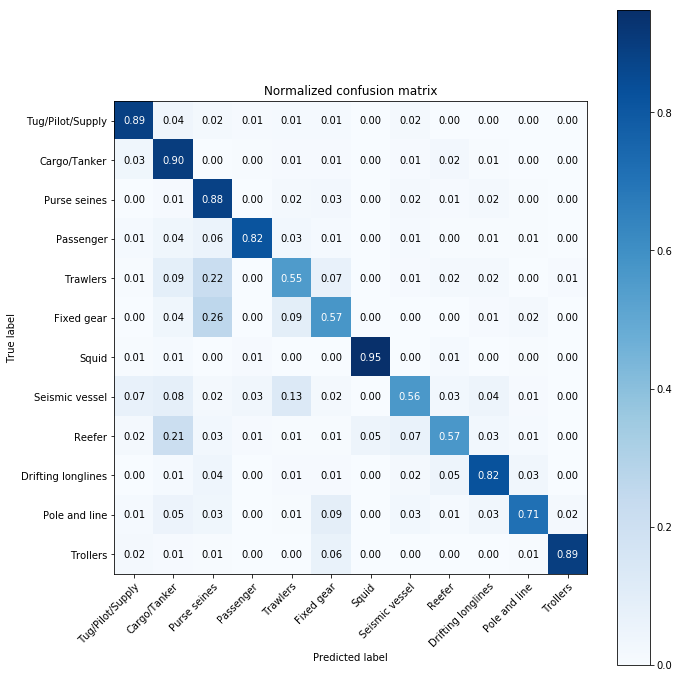

In [90]:
class_names = list(classes.index)
y_pred = rfc_final.predict(x_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      normalize=True)

Normalized confusion matrix
[[8.84e-01 3.83e-02 1.74e-02 8.43e-03 1.44e-02 1.16e-02 2.63e-04 1.97e-02
  3.29e-03 9.22e-04 3.95e-04 1.45e-03]
 [3.73e-02 8.96e-01 3.11e-03 4.20e-03 7.46e-03 9.95e-03 2.33e-03 7.93e-03
  2.32e-02 5.75e-03 2.49e-03 6.22e-04]
 [2.70e-03 9.81e-03 8.82e-01 1.96e-03 1.94e-02 2.50e-02 9.81e-04 2.18e-02
  9.81e-03 2.11e-02 5.64e-03 0.00e+00]
 [1.48e-02 3.96e-02 5.96e-02 8.12e-01 2.78e-02 1.19e-02 5.39e-04 1.51e-02
  4.58e-03 7.82e-03 5.66e-03 8.09e-04]
 [6.84e-03 9.06e-02 2.17e-01 1.71e-03 5.53e-01 7.32e-02 1.37e-03 9.23e-03
  1.88e-02 1.81e-02 0.00e+00 9.91e-03]
 [0.00e+00 3.50e-02 2.66e-01 3.05e-03 8.96e-02 5.75e-01 0.00e+00 2.72e-03
  0.00e+00 9.50e-03 1.87e-02 0.00e+00]
 [4.95e-03 1.15e-02 1.65e-03 8.24e-03 0.00e+00 0.00e+00 9.51e-01 2.47e-03
  1.36e-02 2.47e-03 4.12e-03 0.00e+00]
 [7.24e-02 7.85e-02 2.15e-02 3.18e-02 1.22e-01 1.64e-02 2.80e-03 5.75e-01
  2.43e-02 4.44e-02 1.03e-02 0.00e+00]
 [1.85e-02 2.14e-01 2.94e-02 6.99e-03 7.98e-03 1.05e-02 4.74e-02 6.1

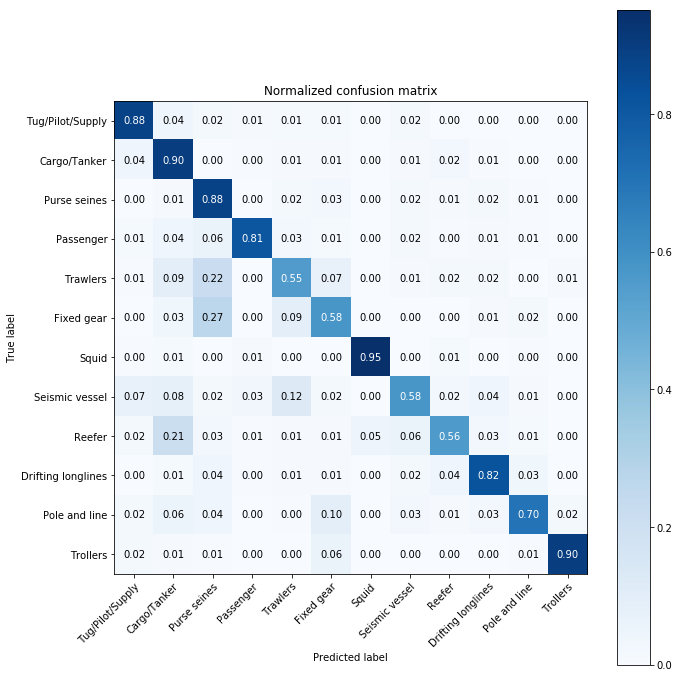

In [91]:
class_names = list(classes.index)
y_pred = rfc_final.predict(x_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names,
                      normalize=True)

In [92]:
#generate feature importance graph
#Plot feature importance
features = rfc_final.feature_importances_

Text(0.5, 1.0, 'Feature Importance from Random Forest Classifier')

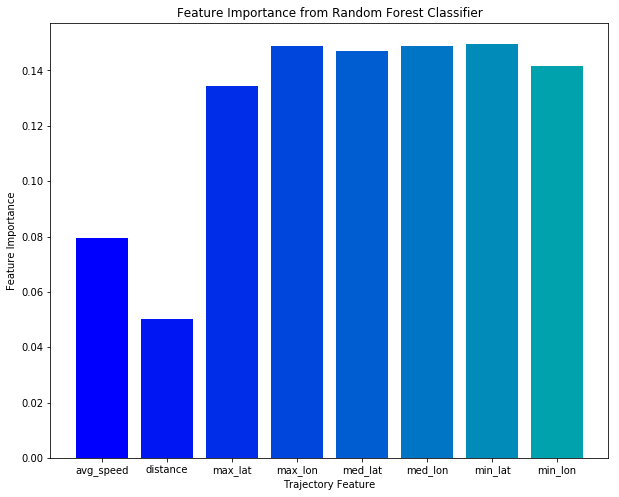

In [98]:
features_list = ['avg_speed','distance','max_lat','max_lon','med_lat','med_lon','min_lat','min_lon']

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.bar(height=features,x=features_list,color=color_list)
ax.set_xlabel("Trajectory Feature")
ax.set_ylabel("Feature Importance")
ax.set_title("Feature Importance from Random Forest Classifier")